In [16]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
import math
import seaborn as sns
from scipy import integrate

#set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [17]:
#load the dataset
Pi = []
filename = "π(x).csv"

with open(filename, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        number_of_primes = int(row[1])  # the second column contains the number of primes below x
        Pi.append(number_of_primes)

#create DataFrame
df = pd.DataFrame({
    "x": [i + 1 for i in range(0, 100000)],  
    "pi_x": [Pi[i] for i in range(0, 100000)]
})

##  Mean Absolute Percentage Error (MAPE)

MAPE measures the average percentage difference between predicted and actual values based on test set. It evaluates how well the model estimates the prime-counting function $\pi(x)$.

###  Formula

$$
\text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{\hat{\pi}(x_i) - \pi(x_i)}{\pi(x_i)} \right|
$$

###  Definitions

- $\hat{\pi}(x_i)$: Predicted number of primes ≤ $x_i$
- $\pi(x_i)$: Actual number of primes ≤ $x_i$
- $n$: Number of data points

###  Steps

1. Compute the absolute percentage error for each test point.
2. Average all errors to get MAPE.
3. A lower MAPE indicates a better-performing model.

---

##  Absolute Percentage Error (APE) of Large Numbers Beyond Training Dataset

To test the model’s ability to generalise beyond the training and test range, we evaluate MAPE at large $x$-values such as:

- $x = 10^6$
- $x = 10^7$
- $x = 10^8$

Since computing the actual prime count for such large $ x $ is computationally expensive (e.g., with the Sieve of Eratosthenes), only a few selected values are tested.

This tests if the model truly captures the behavior of $\pi(x)$, rather than just fitting trends in the training and test data.




#  Simple Linear Regression Model

Predict $\pi(x)$ (number of primes ≤ $x$) using a linear model:

$ \hat{\pi}(x) = wx + b $

Where:
- $x$ is the input number
- $\hat{\pi}(x)$ is the predicted number of primes ≤ $x$

In [18]:
X = df[['x']]
y = df['pi_x']

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

In [19]:
#calculate percentage error
actual = np.array(y_test)
predicted = np.array(y_pred)

#remove zero values to avoid division by zero
mask = actual != 0
actual_non_zero = actual[mask]
predicted_non_zero = predicted[mask]

#calculate percentage errors
percentage_errors = np.abs((actual_non_zero - predicted_non_zero) / actual_non_zero) * 100
mape = np.mean(percentage_errors)

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 9.50%


In [20]:
large_nums=[[10**6], [10**7], [10**8]]
actual_pi_x=[78498, 664579, 5761455] #actual number of primes below each of these large numbers

#calculate percentage errors
y_pred_large = model.predict(large_nums)
percentage_errors = np.abs((actual_pi_x - y_pred_large) / actual_pi_x) * 100

for i in range(0,3):
    print(f"Absolute Percentage Error (APE) for x=10^{5+i}: {percentage_errors[i]:.2f}%")

Absolute Percentage Error (APE) for x=10^5: 19.83%
Absolute Percentage Error (APE) for x=10^6: 41.05%
Absolute Percentage Error (APE) for x=10^7: 62.64%


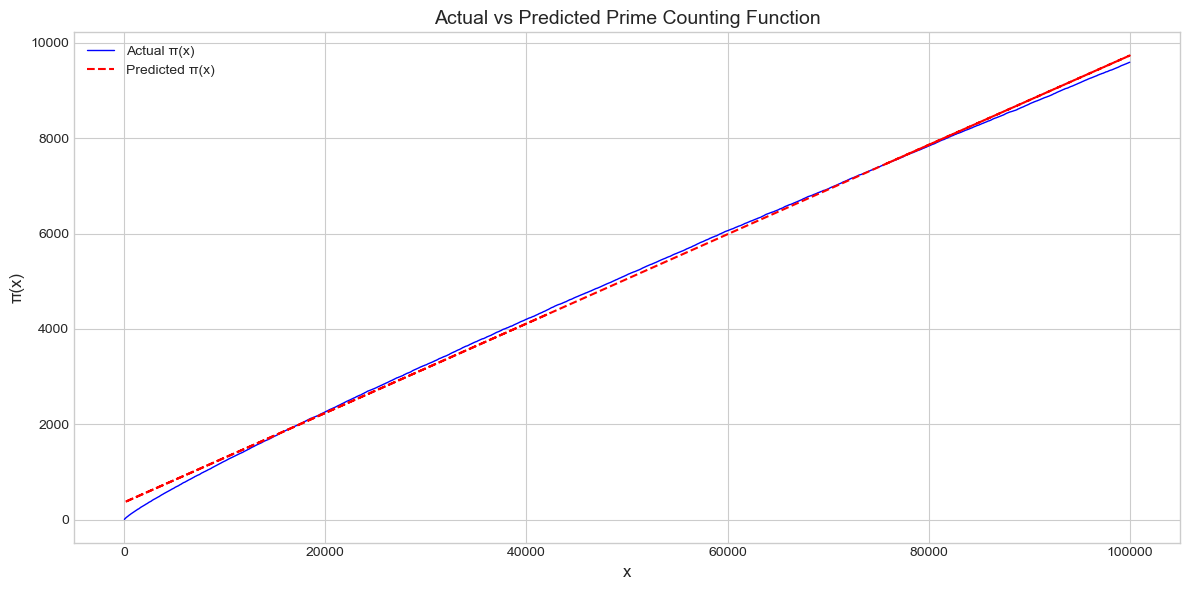

In [21]:
#convert to numpy arrays first
X_test_np = np.array(X_test).flatten()
y_test_np = np.array(y_test)

#sort both X and y together by X values
sorted_indices = np.argsort(X_test_np)
X_sorted = X_test_np[sorted_indices]
y_sorted = y_test_np[sorted_indices]


# plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(X_sorted, y_sorted, 'b-', linewidth=1, label='Actual π(x)')
plt.plot(X_test, y_pred, 'r--', linewidth=1.5, label='Predicted π(x)')
plt.xlabel('x', fontsize=12)
plt.ylabel('π(x)', fontsize=12)
plt.title('Actual vs Predicted Prime Counting Function', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

## Advanced Feature Engineering Based on Number Theory 

We'll create features based on known approximations of π(x) from number theory, these features will be used for Multiple Linear Regression:
- $\dfrac{x}{\ln(x)}$ (Prime Number Theorem)
- $\mathrm{Li}(x)$ (Logarithmic Integral)  
- $\dfrac{x}{\ln(x) - 1.08366}$ (Legendre's approximation)
- Other miscellaneous math functions that may be useful as a feature: $\ln(x)$ , $x^2$ , $\sqrt{x}$ , $(\ln(x))^2$ , $x \ln(x)$

In [22]:
#function  to approximate Li(x) - the logarithmic integral
def li_approx(x):
    if x <= 1:
        return 0
    #use a simple approximation for efficiency
    return x / np.log(x) + 1.04 * x / (np.log(x)**2)

# create feature engineering function
def engineer_features(df, max_samples=None):
    # limit samples if specified
    if max_samples:
        df = df.iloc[:max_samples].copy()
    else:
        df = df.copy()

    # basic transformations
    df['log_x'] = np.log(df['x'])

    # Prime Number Theorem (x/ln(x)) approximation
    df['x_div_logx'] = df['x'] / np.maximum(df['log_x'], 0.001)  # Avoid division by zero
    
    # Logarithmic integral approximation
    df['li_x'] = df['x'].apply(li_approx)
    
    # additional miscellaneous mathematical transformations that may be useful
    df['x_squared'] = df['x'] ** 2
    df['sqrt_x'] = np.sqrt(df['x'])
    df['log_squared'] = df['log_x'] ** 2
    df['x_times_log'] = df['x'] * df['log_x']
    
    # Legendre's approximation
    df['legendre'] = df['x'] / np.maximum(df['log_x'] - 1.08366, 0.001)  # Avoid division by zero
    
    return df

# apply feature engineering to a subset for visualization
df_sample = engineer_features(df.iloc[:1000])
print("Engineered features:")
print(df_sample.head())


Engineered features:
   x  pi_x     log_x   x_div_logx      li_x  x_squared    sqrt_x  log_squared  \
0  1     0  0.000000  1000.000000  0.000000          1  1.000000     0.000000   
1  2     1  0.693147     2.885390  7.214638          4  1.414214     0.480453   
2  3     2  1.098612     2.730718  5.315748          9  1.732051     1.206949   
3  4     2  1.386294     2.885390  5.050014         16  2.000000     1.921812   
4  5     3  1.609438     3.106675  5.114172         25  2.236068     2.590290   

   x_times_log     legendre  
0     0.000000  1000.000000  
1     1.386294  2000.000000  
2     3.295837   200.638181  
3     5.545177    13.217270  
4     8.047190     9.509719  


## Data Preparation and Scaling

Data scaling so model converges faster.

In [23]:
max_samples = 100000  # Use the full dataset
df_model = engineer_features(df, max_samples)

# define features and target
feature_cols = ['x', 'log_x', 'sqrt_x', 'x_div_logx', 'li_x', 'x_squared', 
                'log_squared', 'x_times_log', 'legendre']
X = df_model[feature_cols]
y = df_model['pi_x']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (80000, 9)
Testing set size: (20000, 9)


## Multiple Linear Regression Model with Hyperparameter Optimisation

In [24]:
# create a pipeline for scaling of inputs and lr fitting
linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('model', LinearRegression())  # Linear regression model
])

# define hyperparameter grid
param_grid = {
    'model__fit_intercept': [True, False],
    'model__copy_X': [True, False],
    'model__positive': [True, False],
    'model__n_jobs': [None, -1]
}

# perform grid search with cross-validation
grid_search = GridSearchCV(
    linear_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# fit the grid search to the data
grid_search.fit(X_train, y_train)

# get the best model
best_linear_model = grid_search.best_estimator_

# print best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(-grid_search.best_score_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'model__copy_X': True, 'model__fit_intercept': True, 'model__n_jobs': None, 'model__positive': True}
Best cross-validation score: 17.5928


       Feature  Coefficient
4         li_x  2690.876624
2       sqrt_x    11.571381
8     legendre     2.175970
5    x_squared     2.169495
0            x     0.000000
1        log_x     0.000000
3   x_div_logx     0.000000
6  log_squared     0.000000
7  x_times_log     0.000000


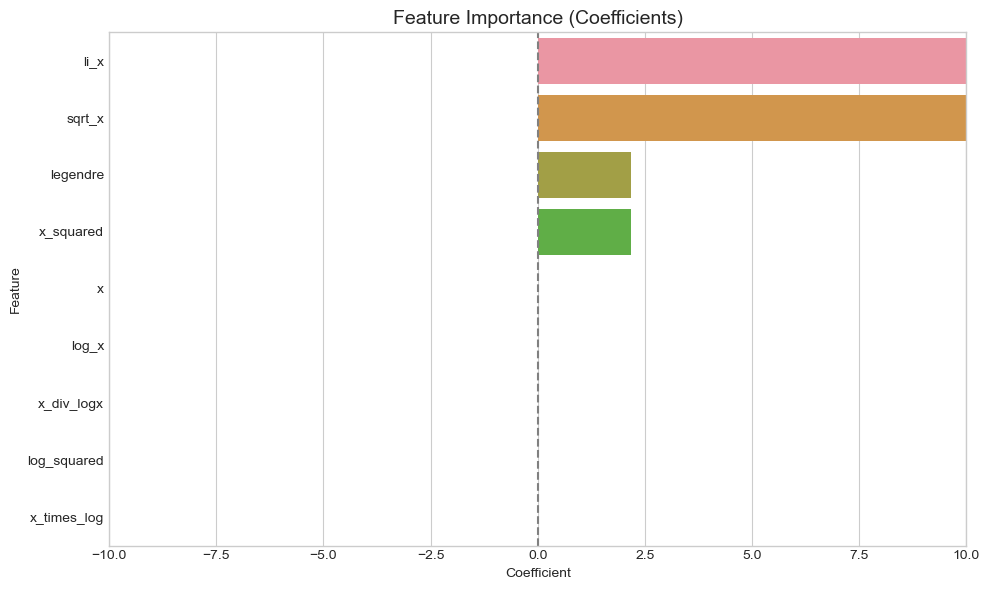

In [25]:
# make predictions with the best model
y_pred_train = best_linear_model.predict(X_train)
y_pred_test = best_linear_model.predict(X_test)

# convert predictions to Series, with same index as X_test
y_pred_series = pd.Series(y_pred_test, index=X_test.index, name='Prediction')

# concatenate
df_combined = pd.concat([X_test, y_pred_series], axis=1)

# get feature importances (coefficients)
coefficients = best_linear_model.named_steps['model'].coef_
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients
})
feature_importance = feature_importance.sort_values('Coefficient', key=abs, ascending=False)
print(feature_importance)


#display feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)

plt.title('Feature Importance (Coefficients)', fontsize=14)

#zoom in on the x-axis: adjust min and max values as needed
plt.xlim(-10, 10)  # or another range that fits your data

plt.axvline(0, color='gray', linestyle='--')  # Optional: add a vertical line at 0
plt.tight_layout()
plt.show()

## Model Evaluation

In [26]:
# function to calculate mape
def evaluate_model(y_true, y_pred, name="Model"):

    # calculate percentage error
    actual = np.array(y_true)
    predicted = np.array(y_pred)
    
    # remove zero values to avoid division by zero
    mask = actual != 0
    actual_non_zero = actual[mask]
    predicted_non_zero = predicted[mask]
    
    # calculate percentage errors
    percentage_errors = np.abs((actual_non_zero - predicted_non_zero) / actual_non_zero) * 100
    mape = np.mean(percentage_errors)
    
    #print results
    print(f"Mean Absolute Percentage Error (MAPE) on {name}: {mape:.2f}%")
  


evaluate_model(y_train, y_pred_train, "Training Set")
evaluate_model(y_test, y_pred_test, "Test Set")

Mean Absolute Percentage Error (MAPE) on Training Set: 0.14%
Mean Absolute Percentage Error (MAPE) on Test Set: 0.12%


In [27]:
large_nums = [[10**6], [10**7], [10**8]]
df_input = pd.DataFrame(large_nums, columns=['x'])

# apply feature engineering
df_features = engineer_features(df_input)

print(df_features)

           x      log_x    x_div_logx          li_x          x_squared  \
0    1000000  13.815511  7.238241e+04  7.783120e+04      1000000000000   
1   10000000  16.118096  6.204207e+05  6.604526e+05    100000000000000   
2  100000000  18.420681  5.428681e+06  5.735175e+06  10000000000000000   

        sqrt_x  log_squared   x_times_log      legendre  
0   1000.00000   190.868332  1.381551e+07  7.854318e+04  
1   3162.27766   259.793007  1.611810e+08  6.651397e+05  
2  10000.00000   339.321479  1.842068e+09  5.768004e+06  


In [28]:
#define the inputs
large_nums = [[10**6], [10**7], [10**8]]
actual_pi_x = np.array([78498, 664579, 5761455])  # Actual number of primes

#create DataFrame
df_large = pd.DataFrame(large_nums, columns=['x'])

#engineer features
df_large_features = engineer_features(df_large)
print(df_large_features)

#extract correct features used in training
model_features = best_linear_model.feature_names_in_  
X_features = df_large_features[model_features]

#predict
y_pred = best_linear_model.predict(X_features)

#calculate and print percentage errors
percentage_errors = np.abs((actual_pi_x - y_pred) / actual_pi_x) * 100

for i in range(3):
    print(f"Absolute Percentage Error (APE) for x=10^{6+i}: {percentage_errors[i]:.2f}%")

           x      log_x    x_div_logx          li_x          x_squared  \
0    1000000  13.815511  7.238241e+04  7.783120e+04      1000000000000   
1   10000000  16.118096  6.204207e+05  6.604526e+05    100000000000000   
2  100000000  18.420681  5.428681e+06  5.735175e+06  10000000000000000   

        sqrt_x  log_squared   x_times_log      legendre  
0   1000.00000   190.868332  1.381551e+07  7.854318e+04  
1   3162.27766   259.793007  1.611810e+08  6.651397e+05  
2  10000.00000   339.321479  1.842068e+09  5.768004e+06  
Absolute Percentage Error (APE) for x=10^6: 0.98%
Absolute Percentage Error (APE) for x=10^7: 11.11%
Absolute Percentage Error (APE) for x=10^8: 126.55%


## Visualise Model Performance

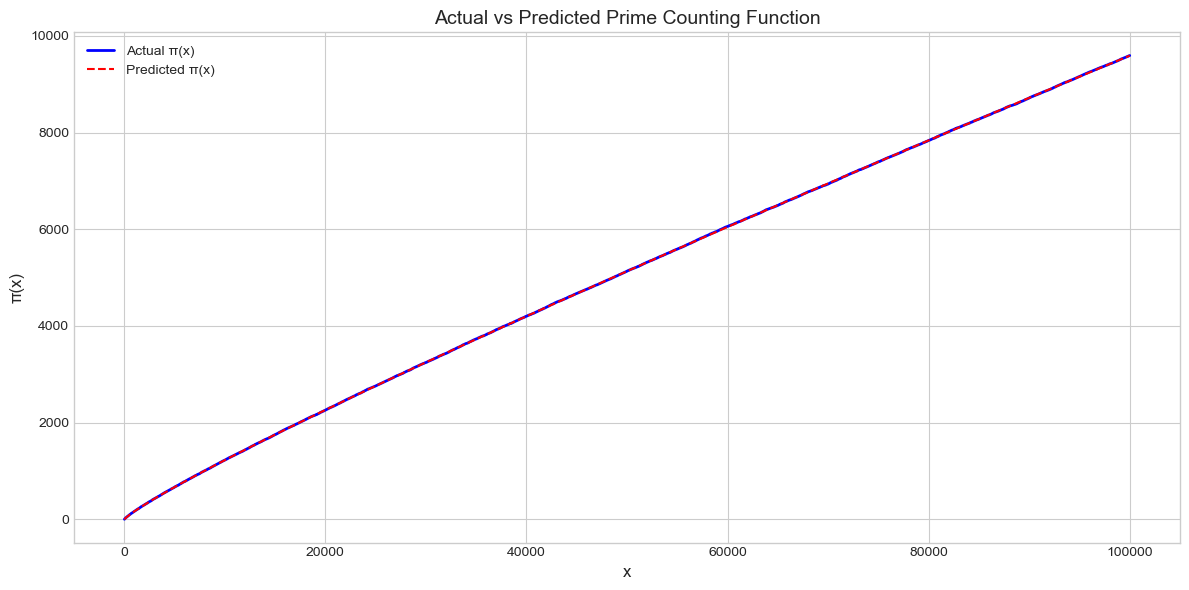

In [29]:
# create a DataFrame for visualisation
results_df = pd.DataFrame({
    'x': X_test['x'],
    'Actual': y_test,
    'Predicted': y_pred_test,
    'Error': y_pred_test - y_test
})

# calculate percentage error
results_df['Percentage_Error'] = np.abs(results_df['Error'] / results_df['Actual']) * 100

# sort by x for better visualization
results_df = results_df.sort_values('x')

# plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['x'], results_df['Actual'], 'b-', linewidth=2, label='Actual π(x)')
plt.plot(results_df['x'], results_df['Predicted'], 'r--', linewidth=1.5, label='Predicted π(x)')
plt.xlabel('x', fontsize=12)
plt.ylabel('π(x)', fontsize=12)
plt.title('Actual vs Predicted Prime Counting Function', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

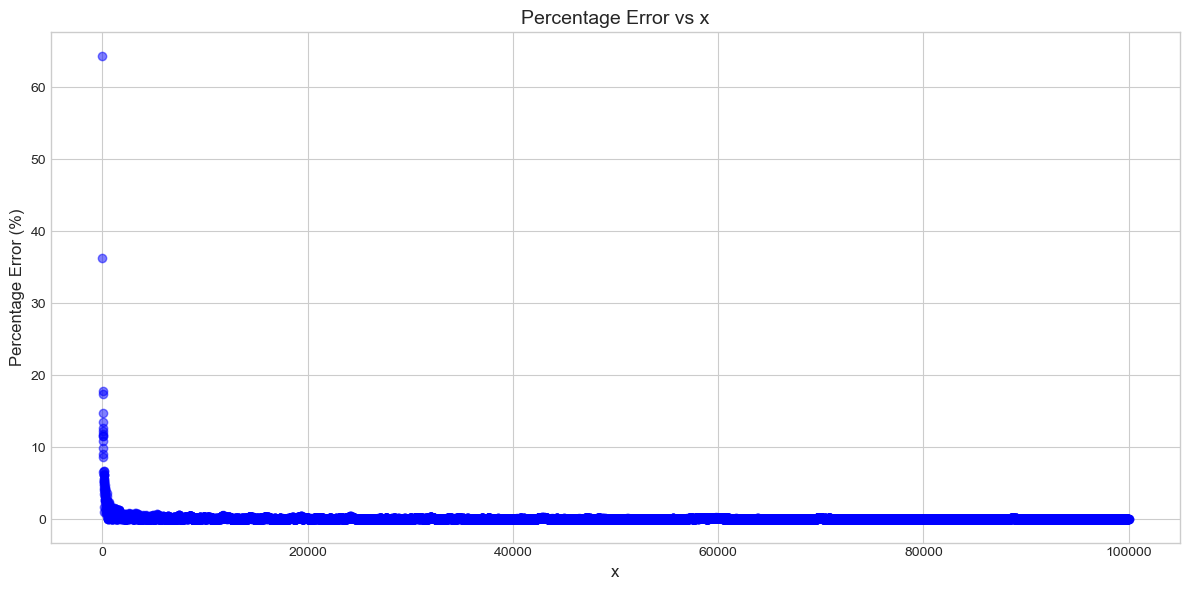

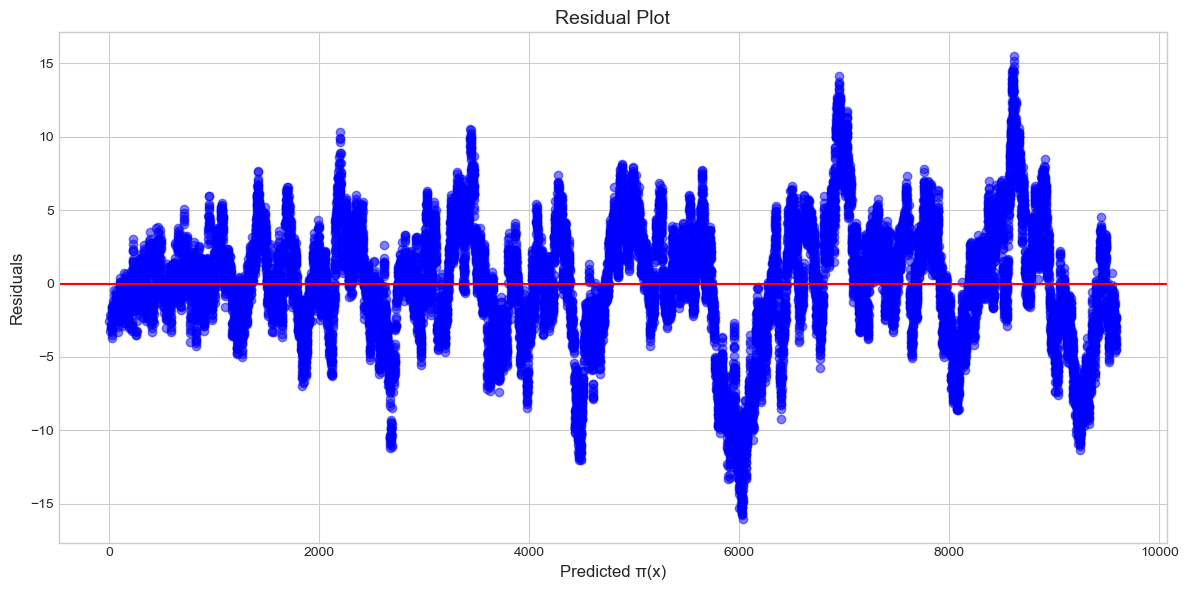

In [30]:
# plot error vs x
plt.figure(figsize=(12, 6))
plt.scatter(results_df['x'], results_df['Percentage_Error'], alpha=0.5, color='blue')
plt.xlabel('x', fontsize=12)
plt.ylabel('Percentage Error (%)', fontsize=12)
plt.title('Percentage Error vs x', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(results_df['Predicted'], results_df['Error'], alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted π(x)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()